In [307]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import time
import pickle
import numpy as np

In [308]:
data = pd.read_csv('../data/Mumbai_House_Price.csv')
# Process type  ( Apartment: 0, Independent House: 1, Studio Apartment: 2, villa: 3 )
# Process status ( Ready to move: 0, under Construction: 1 )
for column in data:
    if column in ["bhk","status","type","age"]:
        print("Column Name: ", column)
        print(data[column].unique())
        print(data[column].value_counts())

Column Name:  bhk
[ 3  2  5  1  4  6  9  8 10  7]
bhk
2     31429
1     24613
3     15273
4      3934
5       606
6       148
7        16
8         8
10        6
9         5
Name: count, dtype: int64
Column Name:  type
['Apartment' 'Villa' 'Studio Apartment' 'Independent House' 'Penthouse']
type
Apartment            74854
Studio Apartment       882
Villa                  226
Independent House       73
Penthouse                3
Name: count, dtype: int64
Column Name:  status
['Ready to move' 'Under Construction']
status
Ready to move         44982
Under Construction    31056
Name: count, dtype: int64
Column Name:  age
['New' 'Resale' 'Unknown']
age
New        38072
Resale     23357
Unknown    14609
Name: count, dtype: int64


In [309]:
def preprocessing(data:pd.DataFrame) -> pd.DataFrame:
    for index in data.index:
        price = data.loc[index, 'price']
        price_unit = data.loc[index, 'price_unit']
        # Process price
        if price_unit == 'Cr':
            data.loc[index, 'price_in_USD'] = (price * 10000000 * 0.012)
        elif price_unit == 'L':
            data.loc[index, 'price_in_USD'] = (price * 100000 * 0.012)
    data.drop(['price_unit',"price","locality","type","status"], axis = 1, inplace = True)
    data = data.dropna()
    return data


In [310]:
processed_data = preprocessing(data)
for column in processed_data:
    print(column)

bhk
area
region
age
price_in_USD


In [311]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X = processed_data.drop(labels="price_in_USD",axis=1)
for column in X:
    if column in ["locality","region", "status", "age","type"]:
        X[column] = le.fit_transform(X[column])
Y = processed_data["price_in_USD"]
print(X.shape)
print(Y.shape)

(76038, 4)
(76038,)


In [312]:
from sklearn.model_selection import train_test_split
X_hold, X_test, Y_hold, Y_test = train_test_split(X,Y,test_size=0.05,random_state=0)
X_train, X_val, Y_train,Y_val = train_test_split(X_hold,Y_hold,test_size=0.05,random_state=0)

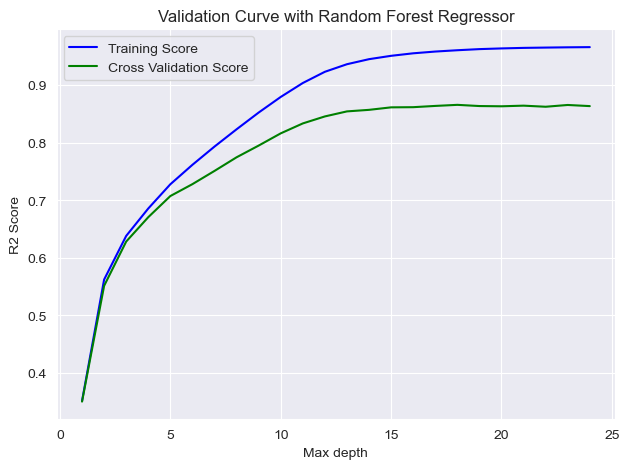

In [313]:
from sklearn.model_selection import validation_curve

parameter_range = np.arange(1, 25, 1)

# Calculate accuracy on training and test set using the
# gamma parameter with 5-fold cross validation
train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=10, random_state=42), X_hold, Y_hold,
                                          param_name="max_depth",
                                          param_range=parameter_range,
                                          cv=4, scoring="r2")

mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

mean_val_score = np.mean(val_score, axis=1)
std_val_score = np.std(val_score, axis=1)

plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_val_score,
         label="Cross Validation Score", color='g')
# Creating the plot
plt.title("Validation Curve with Random Forest Regressor")
plt.xlabel("Max depth")
plt.ylabel("R2 Score")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

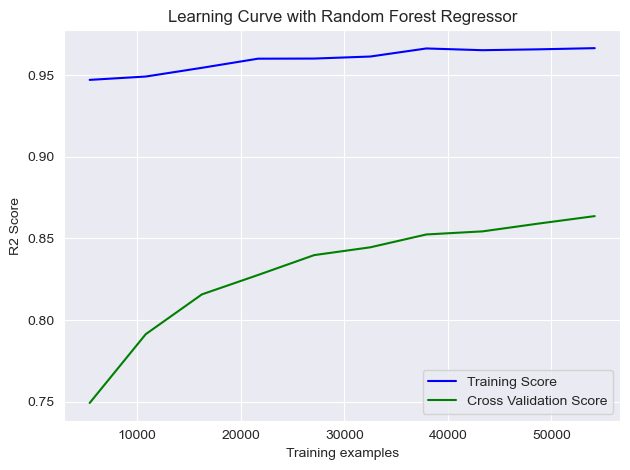

In [314]:
from sklearn.model_selection import learning_curve

# Calculate accuracy on training and test set using the
# gamma parameter with 5-fold cross validation
train_sizes, train_score, val_score = learning_curve(RandomForestRegressor(n_estimators=10, random_state=42), X_hold, Y_hold,
                                          cv=4, train_sizes=np.linspace(0.1, 1.0, 10),scoring="r2")

train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)

val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)

plt.plot(train_sizes, train_score_mean,
         label="Training Score", color='b')
plt.plot(train_sizes, val_score_mean,
         label="Cross Validation Score", color='g')
# Creating the plot
plt.title("Learning Curve with Random Forest Regressor")
plt.xlabel("Training examples")
plt.ylabel("R2 Score")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [315]:
start = time.time()
# Create the model
model = RandomForestRegressor(n_estimators=10, random_state=42)
print("Start training...")
model.fit(X_train, Y_train)
end = time.time()
print("Time execution : ", end - start)
pickle.dump(model, open('../models/RandomForest', 'wb'))

Start training...
Time execution :  1.4610283374786377


In [316]:
loaded_model = pickle.load(open('../models/RandomForest', 'rb'))

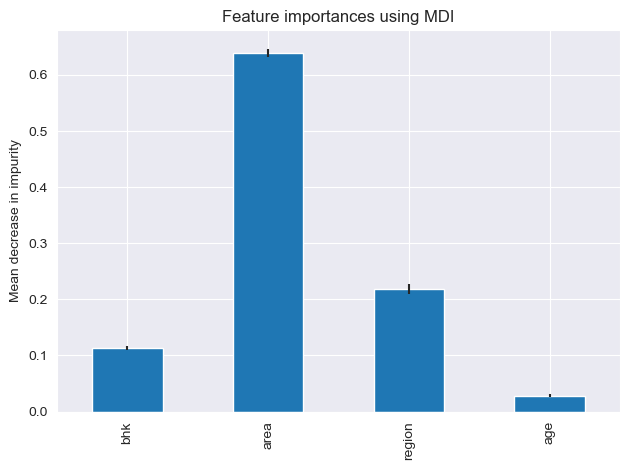

In [317]:
feature_names = [f"{column}" for column in X_train]
importances = loaded_model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in loaded_model.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [318]:
#Make the predictions 
pred_table = pd.DataFrame(data={"actual value":Y_test, "predicted":loaded_model.predict(X_test)})
pred_table["difference"] = pred_table["actual value"] - pred_table["predicted"]
pred_table

,actual value,predicted,difference
30699,99600.0,101840.000000,-2240.000000
36534,186000.0,212400.000000,-26400.000000
23586,39000.0,36340.327273,2659.672727
11125,116400.0,110570.000000,5830.000000
54910,432000.0,523080.000000,-91080.000000
...,...,...,...
60689,117600.0,119756.666667,-2156.666667
48177,91200.0,77797.500000,13402.500000
1309,168000.0,162870.000000,5130.000000
13169,61620.0,64036.800000,-2416.800000


In [319]:
from sklearn.metrics import r2_score
#Test the model
pred_train = loaded_model.predict(X_train)
pred_val = loaded_model.predict(X_val)
pred_test = loaded_model.predict(X_test)
train_accuracy = r2_score(pred_train, Y_train)
val_accuracy = r2_score(pred_val, Y_val)
test_accuracy = r2_score(pred_test, Y_test)
print('Training accuracy: ',train_accuracy)
print('Validation accuracy: ', val_accuracy)
print('Test accuracy: ',test_accuracy)

Training accuracy:  0.964385663913311
Validation accuracy:  0.9074099086347025
Test accuracy:  0.8759791106604256


In [320]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(Y_train, pred_train)
mse_val = mean_squared_error(Y_val, pred_val)
mse_test = mean_squared_error(Y_test, pred_test)
print('Training mean squared error: ', mse_train)
print('Validation mean squared error: ', mse_val)
print('Test mean squared error: ', mse_test)

Training mean squared error:  2328619655.6779175
Validation mean squared error:  5613746937.8027
Test mean squared error:  6601521527.911874


In [321]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(Y_train, pred_train)
mae_val = mean_absolute_error(Y_val, pred_val)
mae_test = mean_absolute_error(Y_test, pred_test)
print('Training mean absolute error: ', mae_train)
print('Validation mean absolute error: ', mae_val)
print('Test mean absolute error: ', mae_test)

Training mean absolute error:  17586.730394342852
Validation mean absolute error:  29641.418194286845
Test mean absolute error:  30360.52810935921
